Denoising with Approximate Total Variation Proximal Operator
============================================================

This example demonstrates use of approximations to the proximal
operators of isotropic <cite data-cite="kamilov-2016-minimizing"/> and anisotropic
<cite data-cite="kamilov-2016-parallel"/> total variation norms for solving
denoising problems using proximal algorithms.

In [1]:
import matplotlib
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize import AcceleratedPGM
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, N - 16), 8)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.5  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with isotropic total variation, solved via ADMM.

In [4]:
λ_iso = 1.0e0
f = loss.SquaredL2Loss(y=y)
g_iso = λ_iso * functional.L21Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape, circular=True)

solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 25}),
    itstat_options={"display": True, "period": 25},
)
print(f"Solving on {device_info()}\n")
x_iso = solver.solve()
print()

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.84e+00  5.211e+04  8.074e+01  5.250e+02      0  0.000e+00


  25  4.32e+00  1.126e+04  2.938e+00  3.424e+01     21  9.329e-05


  50  4.91e+00  1.122e+04  4.725e-01  1.985e+00     12  7.977e-05


  75  5.34e+00  1.122e+04  2.272e-01  6.069e-01      8  7.953e-05


 100  5.66e+00  1.122e+04  1.438e-01  2.506e-01      3  7.145e-05


 125  5.95e+00  1.123e+04  9.858e-02  1.353e-01      2  9.229e-05


 150  6.18e+00  1.123e+04  7.173e-02  7.744e-02      6  8.147e-05


 175  6.40e+00  1.123e+04  5.443e-02  4.393e-02      1  8.955e-05


 199  6.61e+00  1.123e+04  4.351e-02  5.074e-02      3  9.976e-05



Denoise with anisotropic total variation, solved via ADMM.

In [5]:
# Tune the weight to give the same data fidelity as the isotropic case.
λ_aniso = 8.68e-1
g_aniso = λ_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=200,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-4, "maxiter": 25}),
    itstat_options={"display": True, "period": 25},
)
x_aniso = solver.solve()
print()

Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.80e-01  5.644e+04  9.616e+01  6.113e+02      0  0.000e+00


  25  1.25e+00  1.129e+04  2.909e+00  2.886e+01     20  9.048e-05


  50  1.80e+00  1.125e+04  4.511e-01  3.011e+00     12  8.186e-05


  75  2.20e+00  1.126e+04  2.009e-01  1.149e+00      8  8.535e-05


 100  2.48e+00  1.126e+04  1.270e-01  5.457e-01      7  9.685e-05


 125  2.73e+00  1.126e+04  8.725e-02  2.918e-01      3  9.154e-05


 150  2.98e+00  1.126e+04  6.228e-02  1.662e-01      4  9.730e-05


 175  3.18e+00  1.126e+04  4.702e-02  1.064e-01      5  8.658e-05


 199  3.35e+00  1.126e+04  3.475e-02  8.581e-02      2  6.768e-05



Denoise with isotropic total variation, solved using an approximation of
the TV norm proximal operator.

In [6]:
h = λ_iso * functional.IsotropicTVNorm(circular=True, input_shape=y.shape)
solver = AcceleratedPGM(
    f=f, g=h, L0=1e3, x0=y, maxiter=500, itstat_options={"display": True, "period": 50}
)
x_iso_aprx = solver.solve()
print()

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  6.89e-01  5.837e+04  1.000e+03  5.257e-01


  50  1.21e+00  1.549e+04  1.000e+03  3.252e-01
 100  1.36e+00  1.145e+04  1.000e+03  8.900e-02


 150  1.52e+00  1.131e+04  1.000e+03  1.901e-02


 200  1.65e+00  1.129e+04  1.000e+03  6.740e-03
 250  1.79e+00  1.129e+04  1.000e+03  3.808e-03


 300  1.94e+00  1.129e+04  1.000e+03  2.272e-03


 350  2.10e+00  1.129e+04  1.000e+03  1.795e-03


 400  2.28e+00  1.128e+04  1.000e+03  1.134e-03


 450  2.46e+00  1.128e+04  1.000e+03  1.049e-03


 499  2.62e+00  1.128e+04  1.000e+03  6.903e-04



Denoise with anisotropic total variation, solved using an approximation
of the TV norm proximal operator.

In [7]:
h = λ_aniso * functional.AnisotropicTVNorm(circular=True, input_shape=y.shape)
solver = AcceleratedPGM(
    f=f, g=h, L0=1e3, x0=y, maxiter=500, itstat_options={"display": True, "period": 50}
)
x_aniso_aprx = solver.solve()
print()

Iter  Time      Objective  L          Residual 
-----------------------------------------------
   0  4.89e-01  6.545e+04  1.000e+03  6.214e-01
  50  6.66e-01  1.533e+04  1.000e+03  3.705e-01


 100  7.99e-01  1.148e+04  1.000e+03  8.148e-02
 150  9.41e-01  1.137e+04  1.000e+03  1.636e-02


 200  1.07e+00  1.136e+04  1.000e+03  5.840e-03


 250  1.20e+00  1.136e+04  1.000e+03  3.457e-03
 300  1.31e+00  1.135e+04  1.000e+03  1.929e-03


 350  1.44e+00  1.135e+04  1.000e+03  1.592e-03


 400  1.61e+00  1.135e+04  1.000e+03  9.411e-04


 450  1.77e+00  1.135e+04  1.000e+03  9.520e-04
 499  1.95e+00  1.135e+04  1.000e+03  5.801e-04



Compute and print the data fidelity.

In [8]:
for x, name in zip(
    (x_iso, x_aniso, x_iso_aprx, x_aniso_aprx),
    ("Isotropic", "Anisotropic", "Approx. Isotropic", "Approx. Anisotropic"),
):
    df = f(x)
    print(f"Data fidelity for {name} TV: {' ' * (20 - len(name))} {df:.2e}")

Data fidelity for Isotropic TV:             8.69e+03


Data fidelity for Anisotropic TV:           8.69e+03
Data fidelity for Approx. Isotropic TV:     8.68e+03
Data fidelity for Approx. Anisotropic TV:   8.69e+03


Plot results.

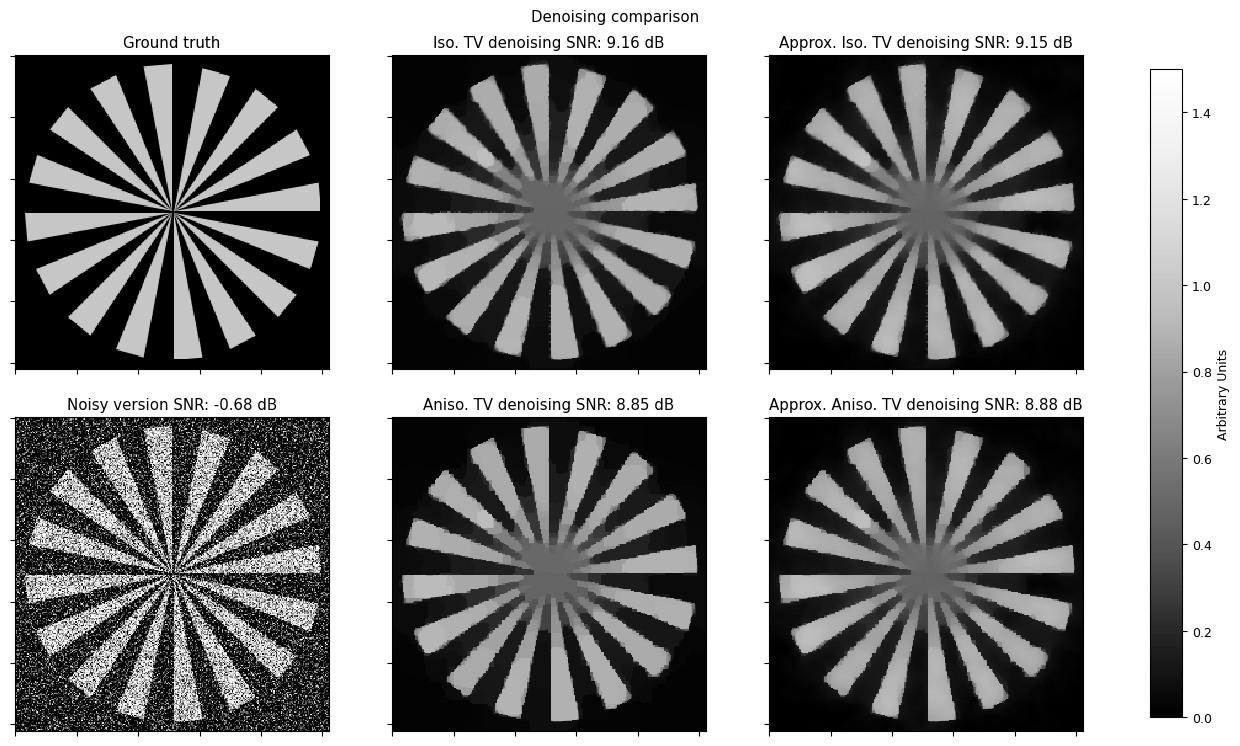

In [9]:
matplotlib.rc("font", size=9)
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15, 8))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(
    y, title=f"Noisy version SNR: {metric.snr(x_gt, y):.2f} dB", fig=fig, ax=ax[1, 0], **plt_args
)
plot.imview(
    x_iso,
    title=f"Iso. TV denoising SNR: {metric.snr(x_gt, x_iso):.2f} dB",
    fig=fig,
    ax=ax[0, 1],
    **plt_args,
)
plot.imview(
    x_aniso,
    title=f"Aniso. TV denoising SNR: {metric.snr(x_gt, x_aniso):.2f} dB",
    fig=fig,
    ax=ax[1, 1],
    **plt_args,
)
plot.imview(
    x_iso_aprx,
    title=f"Approx. Iso. TV denoising SNR: {metric.snr(x_gt, x_iso_aprx):.2f} dB",
    fig=fig,
    ax=ax[0, 2],
    **plt_args,
)
plot.imview(
    x_aniso_aprx,
    title=f"Approx. Aniso. TV denoising SNR: {metric.snr(x_gt, x_aniso_aprx):.2f} dB",
    fig=fig,
    ax=ax[1, 2],
    **plt_args,
)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()